### 1. Dataset preparation

In [1]:
from sklearn.utils import shuffle
import pandas as pd

df = pd.read_csv('all_data.csv', sep=";")

# Drop unite
df = df.drop([0])

# Convert mol -> mmol
for i in df.index:
    df.loc[i, "solubility"] = "{:.1f}".format(float(df.loc[i, "solubility"])*1e3)
    
# We consider missing salt values as 0
df = df.fillna(0)

# We transform all values as numbers
for att in ["temperature", "solubility", "fat", "protein", "salt", "water"]:
    df[att] = df[att].apply(pd.to_numeric)
    

# When a product has been tested multiple times under the same conditions
# We take the mean value
d_values = dict()
for i in df.index:
    key = tuple(df.loc[i].loc[["Type",
                             "temperature",
                             "fat", "protein", "salt",
                             "water"]].to_list() )
    
    if key not in d_values:
        d_values[key] = {"values":list(), "index":list()}
    
    d_values[key]["values"].append( df.loc[i, "solubility"] )
    d_values[key]["index"].append( i )

for key in d_values:
    if len(d_values[key]["index"]) > 1:
        
        mean = sum(d_values[key]["values"])/len(d_values[key]["values"])
        df = df.drop(d_values[key]["index"][1:])
        df.loc[ d_values[key]["index"][0], "solubility" ] = mean

### 2. Learning Preparation

In [2]:
# Define the number of cross-validation
nb_cv = 10

In [3]:
import matplotlib.pyplot as plt

def plot(df, regr):
    """
    Plot the prediction of the dataset in df using the model regr.
    """
    # Define colors for graphs
    d_color = {'Cheese':'orange', 'Fish': 'blue', 'Meat': 'red', 'Oil': 'yellow', 'Water':'white'}
    
    # Initialize graph
    fig, ax = plt.subplots()
    
    y_t = df["solubility"]
    ax.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'k--', lw=2)
    
    # Predict by types
    for t in set(df["Type"]):
        X_t = df.loc[df['Type'] == t][ ["temperature", "fat", "protein", "salt", "water"] ]
        y_t = df.loc[df['Type'] == t]["solubility"]
        
        y_pred = regr.predict(X_t)
        
        ax.scatter(y_t, y_pred, color = d_color[t], edgecolors = 'black')
    
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

### 3. Models Evaluation

Due to the limited size of the dataset, we compute each measure 10 times to have an idea of the average scores.

In [4]:
import random as rd

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

results = {}

#### 3.1. Linear methods
#### 3.1.1 Linear Regression

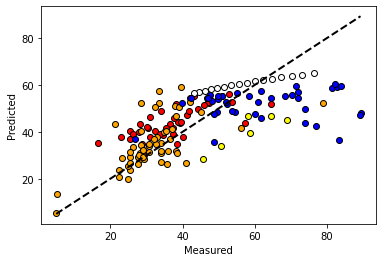

In [5]:
cv_scores = []
loo_scores = []

for r in range(10):
    rd.seed(r)
    
    # Preparation
    df = shuffle(df)
    
    X = df[ ["temperature", "fat", "protein", "salt", "water"] ]
    y = df["solubility"]

    # CV global
    regr = LinearRegression()
    cv_scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )

    # LOO
    pred = list()
    truth = list()
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        regr = LinearRegression()
        regr.fit(X.iloc[train], y.iloc[train])

        pred.append( regr.predict(X.iloc[test])[0] )
        truth.append( y.iloc[test].to_list()[0] )

    cor = np.corrcoef(pred, truth)[0][1]
    loo_scores.append( cor**2 )

# Test plot
regr = LinearRegression()
regr.fit(X, y)
plot(df, regr)

cv_scores = np.array(cv_scores)
loo_scores = np.array(loo_scores)

results["Linear"] = {"CV": "{:.4f} [{:.4f}]".format(cv_scores.mean(), cv_scores.std()),
                     "LOO": "{:.4f} [{:.4f}]".format(loo_scores.mean(), loo_scores.std()) }

#### 3.1.2 Ridge Regression

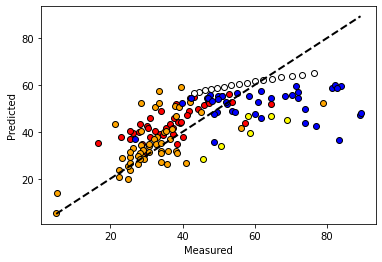

In [6]:
cv_scores = []
loo_scores = []

for r in range(10):
    rd.seed(r)
    
    # Preparation
    df = shuffle(df)
    
    X = df[ ["temperature", "fat", "protein", "salt", "water"] ]
    y = df["solubility"]

    # CV global
    regr = Ridge()
    cv_scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )

    # LOO
    pred = list()
    truth = list()
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        regr = Ridge()
        regr.fit(X.iloc[train], y.iloc[train])

        pred.append( regr.predict(X.iloc[test])[0] )
        truth.append( y.iloc[test].to_list()[0] )

    cor = np.corrcoef(pred, truth)[0][1]
    loo_scores.append( cor**2 )

# Test plot
regr = Ridge()
regr.fit(X, y)
plot(df, regr)

cv_scores = np.array(cv_scores)
loo_scores = np.array(loo_scores)

results["Ridge"] = {"CV": "{:.4f} [{:.4f}]".format(cv_scores.mean(), cv_scores.std()),
                     "LOO": "{:.4f} [{:.4f}]".format(loo_scores.mean(), loo_scores.std()) }

### 3.2. Local Methods
#### 3.2.1. Decision Tree Regression

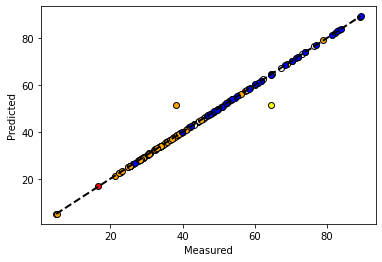

In [7]:
cv_scores = []
loo_scores = []

for r in range(10):
    rd.seed(r)
    
    # Preparation
    df = shuffle(df)
    
    X = df[ ["temperature", "fat", "protein", "salt", "water"] ]
    y = df["solubility"]

    # CV global
    regr = DecisionTreeRegressor()
    cv_scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )

    # LOO
    pred = list()
    truth = list()
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        regr = DecisionTreeRegressor()
        regr.fit(X.iloc[train], y.iloc[train])

        pred.append( regr.predict(X.iloc[test])[0] )
        truth.append( y.iloc[test].to_list()[0] )

    cor = np.corrcoef(pred, truth)[0][1]
    loo_scores.append( cor**2 )

# Test plot
regr = DecisionTreeRegressor()
regr.fit(X, y)
plot(df, regr)

cv_scores = np.array(cv_scores)
loo_scores = np.array(loo_scores)

results["Decision Tree"] = {"CV": "{:.4f} [{:.4f}]".format(cv_scores.mean(), cv_scores.std()),
                     "LOO": "{:.4f} [{:.4f}]".format(loo_scores.mean(), loo_scores.std()) }

#### 3.2.2. K-nearest neighbors regression

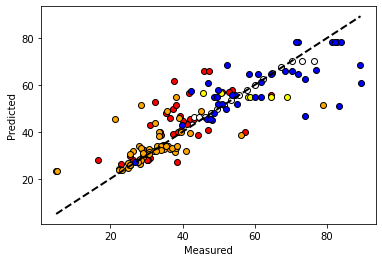

In [8]:
cv_scores = []
loo_scores = []

for r in range(10):
    rd.seed(r)
    
    # Preparation
    df = shuffle(df)
    
    X = df[ ["temperature", "fat", "protein", "salt", "water"] ]
    y = df["solubility"]

    # CV global
    regr = KNeighborsRegressor()
    cv_scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )

    # LOO
    pred = list()
    truth = list()
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        regr = KNeighborsRegressor()
        regr.fit(X.iloc[train], y.iloc[train])

        pred.append( regr.predict(X.iloc[test])[0] )
        truth.append( y.iloc[test].to_list()[0] )

    cor = np.corrcoef(pred, truth)[0][1]
    loo_scores.append( cor**2 )

# Test plot
regr = KNeighborsRegressor()
regr.fit(X, y)
plot(df, regr)

cv_scores = np.array(cv_scores)
loo_scores = np.array(loo_scores)

results["K-nearest neighbors"] = {"CV": "{:.4f} [{:.4f}]".format(cv_scores.mean(), cv_scores.std()),
                     "LOO": "{:.4f} [{:.4f}]".format(loo_scores.mean(), loo_scores.std()) }

### 3.3. Ensemble Methods
#### 3.3.1. Random Forest Regression

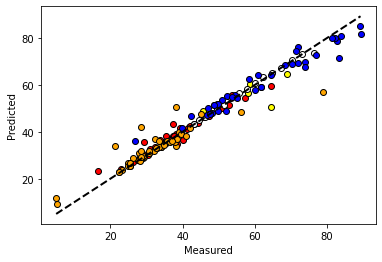

array([0.63916707, 0.64760874, 0.67634647, 0.72306297, 0.68945263,
       0.60432104, 0.64953565, 0.65225556, 0.7147705 , 0.61936046])

In [9]:
cv_scores = []
loo_scores = []

for r in range(10):
    rd.seed(r)
    
    # Preparation
    df = shuffle(df)
    
    X = df[ ["temperature", "fat", "protein", "salt", "water"] ]
    y = df["solubility"]

    # CV global
    regr = RandomForestRegressor()
    cv_scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )

    # LOO
    pred = list()
    truth = list()
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        regr = RandomForestRegressor()
        regr.fit(X.iloc[train], y.iloc[train])

        pred.append( regr.predict(X.iloc[test])[0] )
        truth.append( y.iloc[test].to_list()[0] )

    cor = np.corrcoef(pred, truth)[0][1]
    loo_scores.append( cor**2 )

# Test plot
regr = RandomForestRegressor()
regr.fit(X, y)
plot(df, regr)

cv_scores = np.array(cv_scores)
loo_scores = np.array(loo_scores)

results["Random Forest"] = {"CV": "{:.4f} [{:.4f}]".format(cv_scores.mean(), cv_scores.std()),
                     "LOO": "{:.4f} [{:.4f}]".format(loo_scores.mean(), loo_scores.std()) }

cv_scores

#### 3.3.2. Gradient Boosting Regression

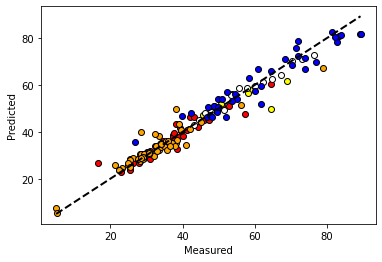

In [11]:
cv_scores = []
loo_scores = []

for r in range(10):
    rd.seed(r)
    
    # Preparation
    df = shuffle(df)
    
    X = df[ ["temperature", "fat", "protein", "salt", "water"] ]
    y = df["solubility"]

    # CV global
    regr = GradientBoostingRegressor()
    cv_scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )

    # LOO
    pred = list()
    truth = list()
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        regr = GradientBoostingRegressor()
        regr.fit(X.iloc[train], y.iloc[train])

        pred.append( regr.predict(X.iloc[test])[0] )
        truth.append( y.iloc[test].to_list()[0] )

    cor = np.corrcoef(pred, truth)[0][1]
    loo_scores.append( cor**2 )

# Test plot
regr = GradientBoostingRegressor()
regr.fit(X, y)
plot(df, regr)

cv_scores = np.array(cv_scores)
loo_scores = np.array(loo_scores)

results["Gradient Boosting"] = {"CV": "{:.4f} [{:.4f}]".format(cv_scores.mean(), cv_scores.std()),
                     "LOO": "{:.4f} [{:.4f}]".format(loo_scores.mean(), loo_scores.std()) }

## 4. Results

In [12]:
pd.DataFrame(results)

,Linear,Ridge,Decision Tree,K-nearest neighbors,Random Forest,Extra Tree,Gradient Boosting
CV,0.3599 [0.0308],0.3682 [0.0390],0.4101 [0.0679],0.4525 [0.0500],0.6616 [0.0369],0.6792 [0.0508],0.6415 [0.0371]
LOO,0.4204 [0.0000],0.4205 [0.0000],0.5522 [0.0157],0.5797 [0.0019],0.7080 [0.0052],0.7149 [0.0042],0.6912 [0.0020]


## 5. Fine tuning
### 5.1. Random Forest

In [13]:
test_trees = [50,100,150,250,500]
cv_scores = { k:[] for k in test_trees }

for n_trees in test_trees:
    scores = []
    
    for r in range(10):
        rd.seed(r)

        # Preparation
        df = shuffle(df)

        X = df[ ["temperature", "fat", "protein", "salt", "water"] ]
        y = df["solubility"]

        # CV global with different number of trees

        regr = RandomForestRegressor(n_estimators=n_trees)
        scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )
            
        
    cv_scores[n_trees] = np.array( scores )
        
results = { k:'{} [{}]'.format( cv_scores[k].mean(), cv_scores[k].std() ) for k in test_trees }
results

{50: '0.6561056403135845 [0.03429246977996914]',
 100: '0.6550000181072358 [0.032526901661758874]',
 150: '0.6762484299903945 [0.024530248265070578]',
 250: '0.6736226845036679 [0.031034684157046053]',
 500: '0.6801967123264739 [0.03616524642409901]'}

## 6. Features importance

We learn the model with only a few features, to see how much information thez bring to the final prediction.

In [15]:
from itertools import combinations
import random as rd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

nb_cv = 10

results = {}

parameters = ["temperature", "fat", "protein", "water", "salt"]
y = df['solubility']

for k in range(1, len(parameters)):
    
    if k not in results:
        results[k] = dict()
    
    # We test all combinations
    for s in combinations(parameters, k):
        
        # Truncated X
        s = list(s)
        X = df[ s ]
        
        # Repeat
        scores = []
        for r in range(10):
            rd.seed(r)
        
            # Learn Truncated Model
            regr = RandomForestRegressor()
            regr.fit(X, y)

            # Evaluation
            scores.append( cross_val_score(regr, X, y, cv=nb_cv).mean() )
            
        scores = np.array(scores)

        results[k][" ".join(sorted(s))] = "{:.4f} [{:.4f}]".format(scores.mean(), scores.std())
        
pd.DataFrame( results )

,1,2,3,4
temperature,0.0442 [0.0051],NaN,NaN,NaN
fat,0.3205 [0.0084],NaN,NaN,NaN
protein,0.3961 [0.0055],NaN,NaN,NaN
water,0.3514 [0.0085],NaN,NaN,NaN
salt,0.2888 [0.0060],NaN,NaN,NaN
fat temperature,NaN,0.4359 [0.0082],NaN,NaN
protein temperature,NaN,0.5336 [0.0101],NaN,NaN
temperature water,NaN,0.6010 [0.0033],NaN,NaN
salt temperature,NaN,0.3422 [0.0046],NaN,NaN
fat protein,NaN,0.3917 [0.0083],NaN,NaN
